In [1]:
import os
import torch.utils.data as data
from PIL import Image
import numpy as np
import torch
import torchvision.transforms as transforms

In [2]:
# getdata
# 默认输入网络的图片大小
IMAGE_SIZE = 200

# 定义一个转换关系，用于将图像数据转换成PyTorch的Tensor形式
dataTransform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),                          # 将图像按比例缩放至合适尺寸
    transforms.CenterCrop((IMAGE_SIZE, IMAGE_SIZE)),        # 从图像中心裁剪合适大小的图像
    transforms.ToTensor()   # 转换成Tensor形式，并且数值归一化到[0.0, 1.0]，同时将H×W×C的数据转置成C×H×W，这一点很关键
])


class DogsVSCatsDataset(data.Dataset):      # 新建一个数据集类，并且需要继承PyTorch中的data.Dataset父类
    def __init__(self, mode, dir):          # 默认构造函数，传入数据集类别（训练或测试），以及数据集路径
        self.mode = mode
        self.list_img = []                  # 新建一个image list，用于存放图片路径，注意是图片路径
        self.list_label = []                # 新建一个label list，用于存放图片对应猫或狗的标签，其中数值0表示猫，1表示狗
        self.data_size = 0                  # 记录数据集大小
        self.transform = dataTransform      # 转换关系

        if self.mode == 'train':            # 训练集模式下，需要提取图片的路径和标签
            dir = dir + '/train/'           # 训练集路径在"dir"/train/
            for file in os.listdir(dir):    # 遍历dir文件夹
                self.list_img.append(dir + file)        # 将图片路径和文件名添加至image list
                self.data_size += 1                     # 数据集增1
                name = file.split(sep='.')              # 分割文件名，"cat.0.jpg"将分割成"cat",".","jpg"3个元素
                # label采用one-hot编码，"1,0"表示猫，"0,1"表示狗，任何情况只有一个位置为"1"，在采用CrossEntropyLoss()计算Loss情况下，label只需要输入"1"的索引，即猫应输入0，狗应输入1
                if name[0] == 'cat':
                    self.list_label.append(0)         # 图片为猫，label为0
                else:
                    self.list_label.append(1)         # 图片为狗，label为1，注意：list_img和list_label中的内容是一一配对的
        elif self.mode == 'test':           # 测试集模式下，只需要提取图片路径就行
            dir = dir + '/test/'            # 测试集路径为"dir"/test/
            for file in os.listdir(dir):
                self.list_img.append(dir + file)    # 添加图片路径至image list
                self.data_size += 1
                self.list_label.append(2)       # 添加2作为label，实际未用到，也无意义
        else:
            print('Undefined Dataset!')

    def __getitem__(self, item):            # 重载data.Dataset父类方法，获取数据集中数据内容
        if self.mode == 'train':                                        # 训练集模式下需要读取数据集的image和label
            img = Image.open(self.list_img[item])                       # 打开图片
            label = self.list_label[item]                               # 获取image对应的label
            return self.transform(img), torch.LongTensor([label])       # 将image和label转换成PyTorch形式并返回
        elif self.mode == 'test':                                       # 测试集只需读取image
            img = Image.open(self.list_img[item])
            return self.transform(img)                                  # 只返回image
        else:
            print('None')

    def __len__(self):
        return self.data_size               # 返回数据集大小


In [3]:
import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F

In [4]:
# network
class Net(nn.Module):                                       # 新建一个网络类，就是需要搭建的网络，必须继承PyTorch的nn.Module父类
    def __init__(self):                                     # 构造函数，用于设定网络层
        super(Net, self).__init__()                         # 标准语句
        self.conv1 = torch.nn.Conv2d(3, 16, 3, padding=1)   # 第一个卷积层，输入通道数3，输出通道数16，卷积核大小3×3，padding大小1，其他参数默认
        self.conv2 = torch.nn.Conv2d(16, 16, 3, padding=1)  # 第二个卷积层，输入通道数16，输出通道数16，卷积核大小3×3，padding大小1，其他参数默认

        self.fc1 = nn.Linear(50*50*16, 128)                 # 第一个全连层，线性连接，输入节点数50×50×16，输出节点数128
        self.fc2 = nn.Linear(128, 64)                       # 第二个全连层，线性连接，输入节点数128，输出节点数64
        self.fc3 = nn.Linear(64, 2)                         # 第三个全连层，线性连接，输入节点数64，输出节点数2

    def forward(self, x):                   # 重写父类forward方法，即前向计算，通过该方法获取网络输入数据后的输出值
        x = self.conv1(x)                   # 第一次卷积
        x = F.relu(x)                       # 第一次卷积结果经过ReLU激活函数处理
        x = F.max_pool2d(x, 2)              # 第一次池化，池化大小2×2，方式Max pooling

        x = self.conv2(x)                   # 第二次卷积
        x = F.relu(x)                       # 第二次卷积结果经过ReLU激活函数处理
        x = F.max_pool2d(x, 2)              # 第二次池化，池化大小2×2，方式Max pooling

        x = x.view(x.size()[0], -1)         # 由于全连层输入的是一维张量，因此需要对输入的[50×50×16]格式数据排列成[40000×1]形式
        x = F.relu(self.fc1(x))             # 第一次全连，ReLU激活
        x = F.relu(self.fc2(x))             # 第二次全连，ReLU激活
        y = self.fc3(x)                     # 第三次激活，ReLU激活

        return y


In [5]:
# from getdata import DogsVSCatsDataset as DVCD
from torch.utils.data import DataLoader as DataLoader
# from network import Net
import torch
from torch.autograd import Variable

In [ ]:
dataset_dir = 'data/'  # 数据集路径

model_cp = 'model/'  # 网络参数保存位置
workers = 10  # PyTorch读取数据线程数量
batch_size = 16  # batch_size大小
lr = 0.0001  # 学习率
nepoch = 10

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")


# .to(device)

def train():
    datafile = DogsVSCatsDataset('train', dataset_dir)  # 实例化一个数据集
    dataloader = DataLoader(datafile, batch_size=batch_size, shuffle=True, num_workers=workers,
                            drop_last=True)  # 用PyTorch的DataLoader类封装，实现数据集顺序打乱，多线程读取，一次取多个数据等效果

    print('Dataset loaded! length of train set is {0}'.format(len(datafile)))

    model = Net()  # 实例化一个网络
    model = model.to(device)  # 网络送入GPU，即采用GPU计算，如果没有GPU加速，可以去掉".cuda()"
    # model = model
    # model = nn.DataParallel(model)
    model.train()  # 网络设定为训练模式，有两种模式可选，.train()和.eval()，训练模式和评估模式，区别就是训练模式采用了dropout策略，可以放置网络过拟合

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)  # 实例化一个优化器，即调整网络参数，优化方式为adam方法

    criterion = torch.nn.CrossEntropyLoss()  # 定义loss计算方法，cross entropy，交叉熵，可以理解为两者数值越接近其值越小

    cnt = 0  # 训练图片数量
    for epoch in range(nepoch):
        # 读取数据集中数据进行训练，因为dataloader的batch_size设置为16，所以每次读取的数据量为16，即img包含了16个图像，label有16个
        for img, label in dataloader:  # 循环读取封装后的数据集，其实就是调用了数据集中的__getitem__()方法，只是返回数据格式进行了一次封装
            img, label = Variable(img).to(device), Variable(label).to(
                device)  # 将数据放置在PyTorch的Variable节点中，并送入GPU中作为网络计算起点
            out = model(img)  # 计算网络输出值，就是输入网络一个图像数据，输出猫和狗的概率，调用了网络中的forward()方法
            loss = criterion(out,
                             label.squeeze())  # 计算损失，也就是网络输出值和实际label的差异，显然差异越小说明网络拟合效果越好，此处需要注意的是第二个参数，必须是一个1维Tensor
            loss.backward()  # 误差反向传播，采用求导的方式，计算网络中每个节点参数的梯度，显然梯度越大说明参数设置不合理，需要调整
            optimizer.step()  # 优化采用设定的优化方法对网络中的各个参数进行调整
            optimizer.zero_grad()  # 清除优化器中的梯度以便下一次计算，因为优化器默认会保留，不清除的话，每次计算梯度都回累加
            cnt += 1

            print('Epoch:{0},Frame:{1}, train_loss {2}'.format(epoch, cnt * batch_size,
                                                               loss / batch_size))  # 打印一个batch size的训练结果

    torch.save(model.state_dict(), '{0}/model.pth'.format(model_cp))  # 训练所有数据后，保存网络的参数


train()

In [6]:
# from getdata import DogsVSCatsDataset as DVCD
# from network import Net
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
import random
import os
# import getdata

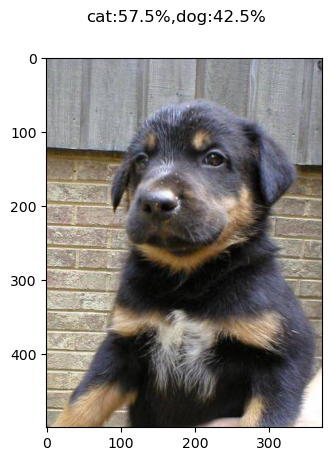

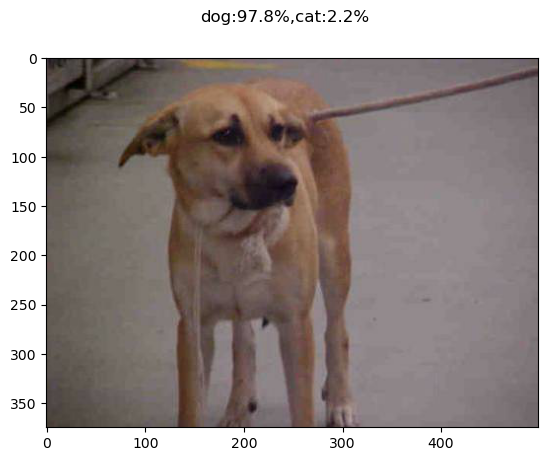

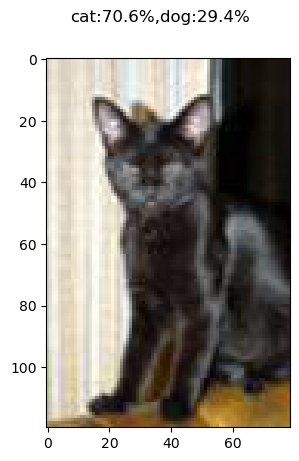

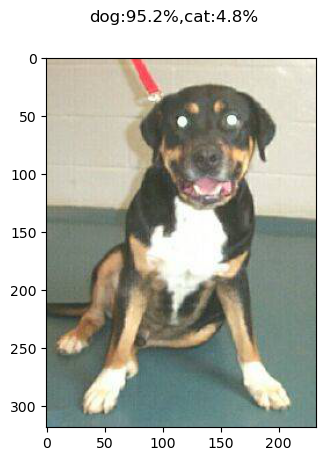

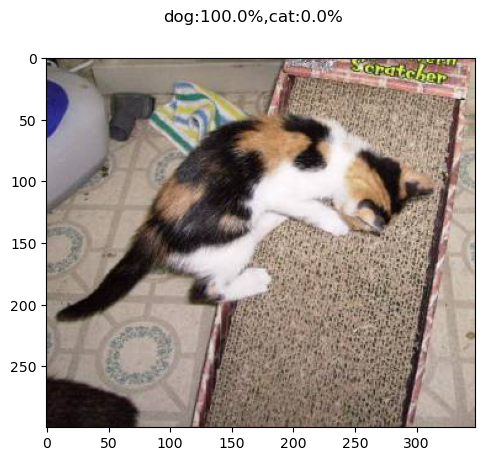

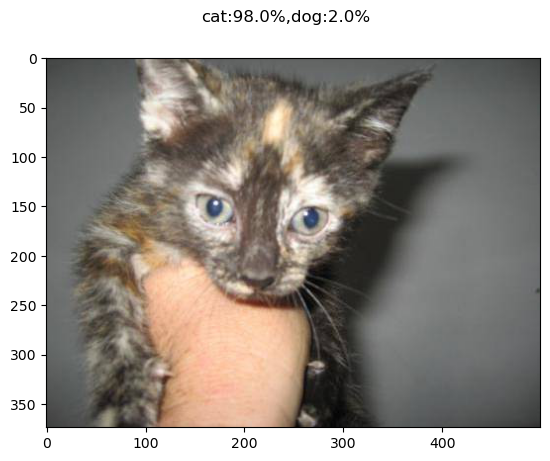

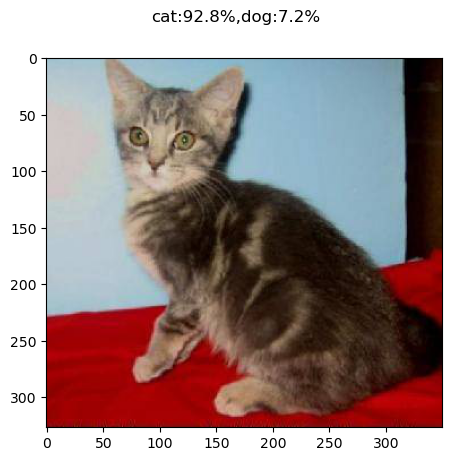

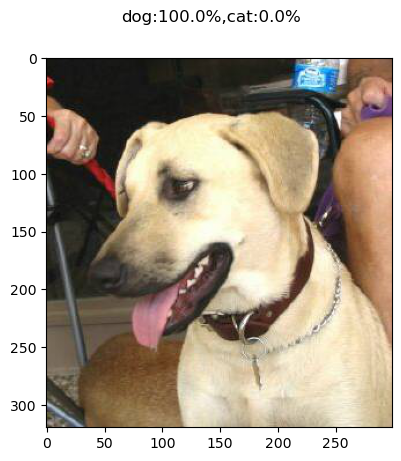

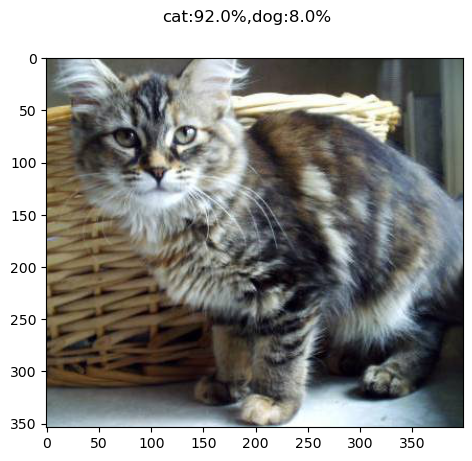

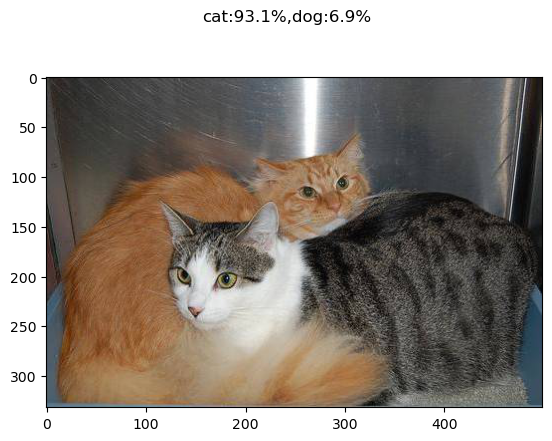

In [7]:
dataset_dir = 'data/test/'                    # 数据集路径
model_file = 'model/model.pth'                # 模型保存路径
N = 10

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

def test():

    # setting model
    model = Net()                                       # 实例化一个网络
    model.to(device)                                       # 送入GPU，利用GPU计算
    model.load_state_dict(torch.load(model_file))       # 加载训练好的模型参数
    model.eval()                                        # 设定为评估模式，即计算过程中不要dropout

    # get data
    files = random.sample(os.listdir(dataset_dir), N)   # 随机获取N个测试图像
    imgs = []           # img
    imgs_data = []      # img data
    for file in files:
        img = Image.open(dataset_dir + file)            # 打开图像
        img_data = dataTransform(img).to(device)           # 转换成torch tensor数据   ++

        imgs.append(img)                                # 图像list
        imgs_data.append(img_data)                      # tensor list
    imgs_data = torch.stack(imgs_data)                  # tensor list合成一个4D tensor

    # calculation
    out = model(imgs_data)                              # 对每个图像进行网络计算
    out = F.softmax(out, dim=1)                         # 输出概率化
    out = out.data.cpu().numpy()                        # 转成numpy数据

    # pring results         显示结果
    for idx in range(N):
        plt.figure()
        if out[idx, 0] > out[idx, 1]:
            plt.suptitle('cat:{:.1%},dog:{:.1%}'.format(out[idx, 0], out[idx, 1]))
        else:
            plt.suptitle('dog:{:.1%},cat:{:.1%}'.format(out[idx, 1], out[idx, 0]))
        plt.imshow(imgs[idx])
    plt.show()


test()